<a href="https://colab.research.google.com/github/roggersanguzu/tomato-disease-detector/blob/main/AI_Based_Tomato_Health_Monitoring_For_Farmers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GROUP THREE MEMBERS.


*   Roggers Anguzu 667137
*   Abdiaziz Ibrahim Kar 668931
*   Shawn Njoroge 668730
*   Audry Imbukwa 670682



#AI Based Tomato Health Monitoring For Farmers
Below is how we searched for the Data and the various Sources.


Here are some of the Keywords that we used in Our Data search.

For Tomato Mosaic [Mosaic, Tomato Mosaic Disease, Tomato Mosaic Leaves]


*   (Tomato leaves) AND (Mosaic Virus)
*   (Tomato Mosaic leaves) OR (Tomato Mosaic Virus)


For Tomato Septoria Datasets [Septotia, Septoria tomato disease]

For Tomato Septoria Datasets [Septotia, Septoria tomato disease]

For Tomato Blight Datasets [Blight, Tomato Blight, Tomato Blight Disease]

For Healthy  Tomato Datasets[Healthy Tomato Leaves, Healthy tomato]



Here are the Various Techniques used in Data Collections.

*   Manually
*   Scrapping using a python Sript
*   Hybrid Technique using both Manual and python scrapping tools[Selenium]


In [86]:
# Install required packages (run this once in Colab)
!pip install -q tensorflow scikit-learn matplotlib seaborn

In [87]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

# Keras and transfer learning tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Sklearn for evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


Our Objective here is to download the Datasets that has been stored on our GoogleDrive and stored in sample_data folder

In [88]:
import shutil

shutil.rmtree('/content/sample_data/Tomato/Tomato Health', ignore_errors=True)

!unzip -qo Tomato.zip -d /content/sample_data/Tomato

base_dir = "/content/sample_data/Tomato/Tomato Health"

class_folders = ['blightTomatoes', 'healthyTomatoes', 'mosaicTomatoes', 'septoriaTomatoes']


 Check for Corrupt Images

In [89]:
CHECK_IMAGES = True  # Set to True to verify images

if CHECK_IMAGES:
    from PIL import Image
    from tqdm import tqdm

    def check_images(folder_path):
        print("Verifying image integrity...")
        bad_files = []
        for label in os.listdir(folder_path):
            class_dir = os.path.join(folder_path, label)
            for file in tqdm(os.listdir(class_dir), desc=f"Checking {label}"):
                try:
                    img_path = os.path.join(class_dir, file)
                    img = Image.open(img_path)
                    img.verify()
                except Exception:
                    bad_files.append(img_path)
        print(f"Found {len(bad_files)} corrupted files.")
        return bad_files

    check_images(base_dir)


Verifying image integrity...


Checking septoriaTomatoes: 100%|██████████| 500/500 [00:00<00:00, 5720.64it/s]

Found 0 corrupted files.


Data Augmentation & Split (80/20)

In [90]:
img_size = 224
batch_size = 32

# Augment and normalize the data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training percentage (80%)
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=class_folders # Specify the class folders
)

# Validation percentage (20%)
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=class_folders # Specify the class folders
)

Found 1508 images belonging to 4 classes.
Found 377 images belonging to 4 classes.


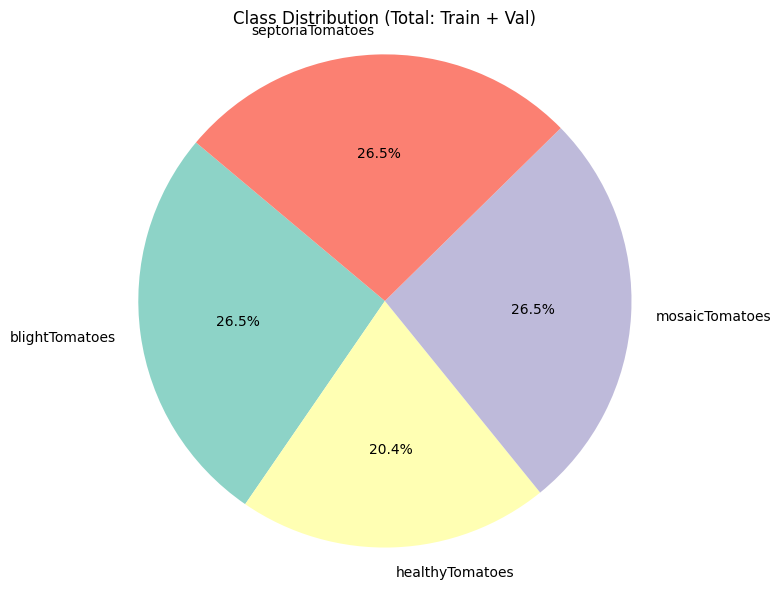

In [95]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(train_generator.class_indices.keys())
class_counts = np.bincount(train_generator.classes)
# Combine train + val counts
val_counts = np.bincount(val_generator.classes)
total_counts = class_counts + val_counts

# Pie chart of overall dataset
plt.figure(figsize=(7, 7))
plt.pie(total_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title("Class Distribution (Total: Train + Val)")
plt.axis('equal')
plt.show()


Compute Class Weights (Important for Mosaic Emphasis)

In [91]:
y_train = train_generator.classes
class_weights = dict(zip(
    np.unique(y_train),
    compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
))

print("Class Weights:", class_weights)


Class Weights: {np.int32(0): np.float64(0.9425), np.int32(1): np.float64(1.224025974025974), np.int32(2): np.float64(0.9425), np.int32(3): np.float64(0.9425)}


Build Transfer Learning Model (MobileNetV2)

In [92]:
# Load pre-trained MobileNetV2 without top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base model

# Custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

# Build model
model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Model with Checkpoints

In [93]:
# Setup callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.4937 - loss: 1.2786
Epoch 1: val_accuracy improved from -inf to 0.71883, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 722ms/step - accuracy: 0.4957 - loss: 1.2729 - val_accuracy: 0.7188 - val_loss: 0.7796
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7572 - loss: 0.6168
Epoch 2: val_accuracy improved from 0.71883 to 0.73740, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 471ms/step - accuracy: 0.7575 - loss: 0.6160 - val_accuracy: 0.7374 - val_loss: 0.7392
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8339 - loss: 0.4881
Epoch 3: val_accuracy improved from 0.73740 to 0.74271, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - accuracy: 0.8341 - loss: 0.4876 - val_accuracy: 0.7427 - val_loss: 0.6795
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8543 - loss: 0.3996
Epoch 4: val_accuracy improved from 0.74271 to 0.76393, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 469ms/step - accuracy: 0.8543 - loss: 0.3995 - val_accuracy: 0.7639 - val_loss: 0.6617
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8731 - loss: 0.3740
Epoch 5: val_accuracy improved from 0.76393 to 0.77188, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 465ms/step - accuracy: 0.8733 - loss: 0.3736 - val_accuracy: 0.7719 - val_loss: 0.6565
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8752 - loss: 0.3591
Epoch 6: val_accuracy improved from 0.77188 to 0.78780, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 472ms/step - accuracy: 0.8753 - loss: 0.3588 - val_accuracy: 0.7878 - val_loss: 0.6502
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8898 - loss: 0.3045
Epoch 7: val_accuracy did not improve from 0.78780
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step - accuracy: 0.8897 - loss: 0.3047 - val_accuracy: 0.7639 - val_loss: 0.6881
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8976 - loss: 0.2790
Epoch 8: val_accuracy did not improve from 0.78780
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - accuracy: 0.8977 - loss: 0.2788 - val_accuracy: 0.7825 - val_loss: 0.6609
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9026 - loss: 0.2687
Epoch 9: val_accuracy did not improve from 0.78780
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 461ms/step - accuracy: 0.9027 - loss: 0.2687 - val_accuracy: 0.7825 - val_loss: 0.6814
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9176 - loss: 0.2417
Epoch 10: val_accuracy improve

48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step - accuracy: 0.9176 - loss: 0.2418 - val_accuracy: 0.7905 - val_loss: 0.6237
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9041 - loss: 0.2511
Epoch 11: val_accuracy did not improve from 0.79045
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.9042 - loss: 0.2511 - val_accuracy: 0.7825 - val_loss: 0.6417
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9035 - loss: 0.2665
Epoch 12: val_accuracy did not improve from 0.79045
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 471ms/step - accuracy: 0.9037 - loss: 0.2660 - val_accuracy: 0.7825 - val_loss: 0.6895
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9249 - loss: 0.2082
Epoch 13: val_accuracy improved from 0.79045 to 0.80902, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 476ms/step - accuracy: 0.9250 - loss: 0.2083 - val_accuracy: 0.8090 - val_loss: 0.6053
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9369 - loss: 0.2159
Epoch 14: val_accuracy did not improve from 0.80902
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 469ms/step - accuracy: 0.9367 - loss: 0.2161 - val_accuracy: 0.7878 - val_loss: 0.6159
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9394 - loss: 0.1841
Epoch 15: val_accuracy did not improve from 0.80902
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.9393 - loss: 0.1844 - val_accuracy: 0.8090 - val_loss: 0.6351
Epoch 16/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9396 - loss: 0.1778
Epoch 16: val_accuracy did not improve from 0.80902
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 459ms/step - accuracy: 0.9394 - loss: 0.1782 - val_accuracy: 0.7931 - val_loss: 0.6242
Epoch 17/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9408 - loss: 0.1970
Epoch 17: val_accuracy d

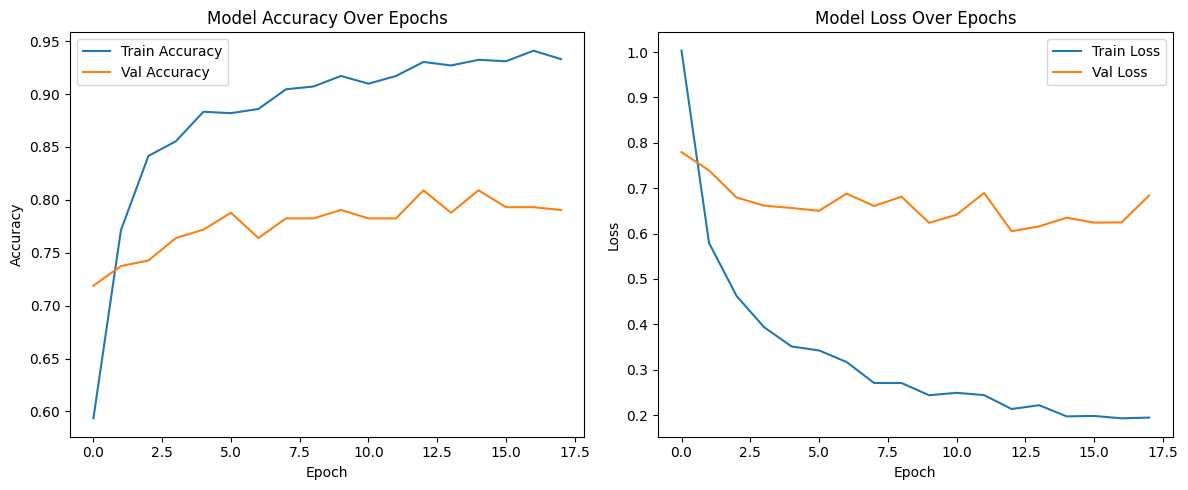

In [96]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Visualize Training Performance

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 561ms/step
Classification Report:

                  precision    recall  f1-score   support

  blightTomatoes       0.83      0.84      0.84       100
 healthyTomatoes       0.82      0.64      0.72        77
  mosaicTomatoes       0.75      0.82      0.78       100
septoriaTomatoes       0.86      0.91      0.88       100

        accuracy                           0.81       377
       macro avg       0.81      0.80      0.80       377
    weighted avg       0.81      0.81      0.81       377



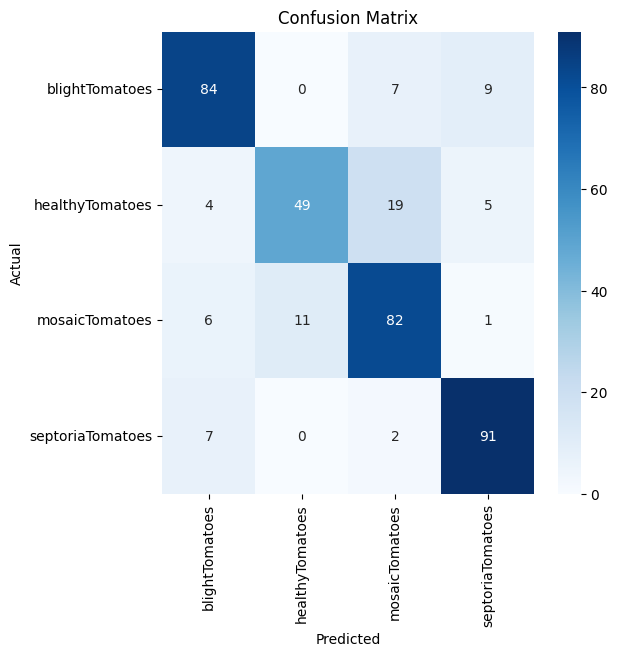

In [98]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# Get actual classes present in y_true
unique_classes = np.unique(y_true)
class_labels = [k for k, v in val_generator.class_indices.items() if v in unique_classes]

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Save Your Model

In [101]:
# Save final model to Google Drive
model.save('/content/sample_data/tomato_disease_model_final.h5')
print("Model saved!")


Model saved!


Deploy with Gradio (fastest, cleanest for demo/testing)

In [102]:
!pip install gradio --quiet
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load trained model
model = tf.keras.models.load_model('/content/sample_data/tomato_disease_model_final.h5')

# Define class labels
class_names = ['blightTomatoes', 'healthyTomatoes', 'mosaicTomatoes', 'saptoriaTomatoes']

def predict_image(img):
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = img_array[np.newaxis, ...]

    preds = model.predict(img_array)
    pred_label = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    return {label: float(prob) for label, prob in zip(class_names, preds[0])}


In [104]:
gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=4),
    title=" Tomato Disease Classifier",
    description="Upload an image of a tomato leaf to detect if it's healthy or has mosaic, blight, or septoria."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://098c846319c1d5f4e0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
